In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/PSC/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json   #r&w permissions for owner 

## Importing libraries

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 7.9 MB/s 
     |████████████████████████████████| 2.3 MB 50.9 MB/s 
     |████████████████████████████████| 54 kB 4.1 MB/s 
     |████████████████████████████████| 84 kB 4.2 MB/s 
     |████████████████████████████████| 213 kB 58.1 MB/s 
     |████████████████████████████████| 106 kB 65.2 MB/s 
     |████████████████████████████████| 278 kB 52.2 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 55 kB 4.7 MB/s 
     |████████████████████████████████| 56 kB 5.4 MB/s 
     |████████████████████████████████| 64 kB 3.6 MB/s 
     |████████████████████████████████| 80 kB 11.7 MB/s 
     |████████████████████████████████| 68 kB 8.8 MB/s 
     |████████████████████████████████| 68 kB 9.2 MB/s 
     |████████████████████████████████| 68 kB 7.8 MB/s 
     |████████████████████████████████| 68 kB 8.3 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd
import gradio

## Data Preprocessing
**Getting training,and testing dataset**

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))               # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_data('/content/drive/MyDrive/PSC/chest_xray/train')
test = get_data('/content/drive/MyDrive/PSC/chest_xray/test')    

<ipython-input-9-1817a4672b4b>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


**Splitting x and y labels of training and testing dataset**

In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [ ]:
positives=[]
negatives=[]
for i in range(len(y_train)):
    if y_train[i]:
        positives.append(x_train[i])
    else:
        negatives.append(x_train[i])

COUNT:  (array([0, 1]), array([3875, 1341]))
--------------------------------------------------------------------------------


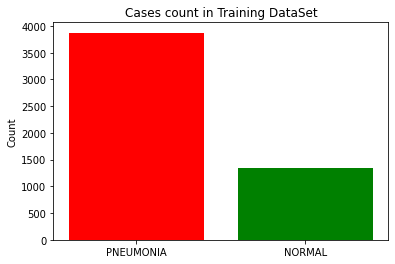

In [ ]:
print("COUNT: ",np.unique(y_train, return_counts=True))
print("--------------------------------------------------------------------------------")

plt.bar(labels, [len(negatives), len(positives)], color=["red", "green"])
plt.title("Cases count in Training DataSet")
plt.ylabel("Count")
plt.show()

#Pneumonia-Class 0
#Normal   -Class 1

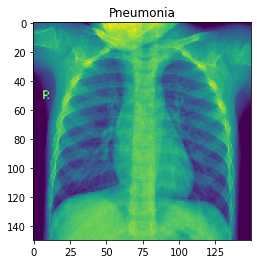

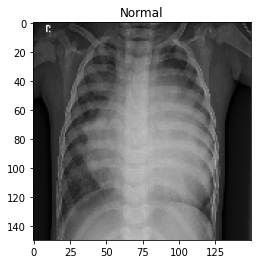

In [ ]:
plt.imshow(positives[0])
plt.title("Pneumonia")
plt.show()

plt.imshow(negatives[4], cmap="gray")
plt.title("Normal")
plt.show()

**Performing a grayscale normalization to reduce the effect of illumination's differences.**

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

**Resizing the data for CNN training and testing**

In [ ]:
# Fit ANN to training set
# resize data for deep network learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
print("X_train shape:",x_train.shape)
#print("Y_train shape:",y_train.shape)

print("X_test shape:",x_test.shape)
#print("Y_test shape:",y_test.shape)

X_train shape: (5216, 150, 150, 1)
X_test shape: (624, 150, 150, 1)


In [ ]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
print("Y_train shape:",y_train.shape)
print("Y_test shape:",y_test.shape)

Y_train shape: (5216, 1)
Y_test shape: (624, 1)


## Data augmentation

In order to avoid overfitting problem, we can expand artificially our dataset. This can be done by altering the training data with small transformations to reproduce the variations. 

Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 20,   # randomly rotate images in the range (degrees, 0 to 180)                       #CHANEGD 30 to 20
        zoom_range = 0.2,      # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [ ]:
model = Sequential()

#convolutional layer with ReLu HIDDEN LAYER                 #CHANGED:    ,strides = 1 , padding = 'same',
model.add(Conv2D(32, kernel_size=(3, 3),strides = 1 , padding = 'same',activation='relu', input_shape=x_test[0].shape))        #32 convolution filters used each of size 3x3
model.add(MaxPool2D(pool_size=(2, 2), strides = 2 , padding = 'same')) 

model.add(Conv2D(64, (3, 3),strides = 1 , padding = 'same', activation='relu'))                                                #64 convolution filters used each of size 3x3 
model.add(MaxPool2D(pool_size=(2, 2), strides = 2 , padding = 'same'))                                                    #choosing best features via pooling
#model.add(Dropout(0.25))                                                                        #randomly turn neurons on and off to improve convergence

#increased layers
model.add(Conv2D(64, (3, 3), strides = 1 , padding = 'same' , activation='relu'))                                                #64 convolution filters used each of size 3x3 
model.add(MaxPool2D(pool_size=(2, 2), strides = 2 , padding = 'same'))                                                      #choosing best features via pooling
#model.add(Dropout(0.25))

model.add(Flatten())                                                                             #flatenning inputs
#model.add(Dense(128, activation='relu'))                                                         #fully connected feed forward network to get required output
#model.add(Dropout(0.5))                                                                          #dropout for convergence sake 

model.add(Dense(units = 1, activation='sigmoid'))                                                    
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])       
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 19, 64)       0

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience = 2, 
                                            verbose=1,
                                            factor=0.3,cooldown=1, 
                                            min_lr=0.001)             #CHANGED:0.000001 TO 0.001,ADDED cooldown=1, 

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32),
                    epochs = 50,
                    callbacks = learning_rate_reduction)

Epoch 1/50
163/163 [==============================] - 185s 1s/step - loss: 0.4512 - accuracy: 0.7874 - lr: 0.0010
Epoch 2/50
163/163 [==============================] - 187s 1s/step - loss: 0.2955 - accuracy: 0.8731 - lr: 0.0010
Epoch 3/50
163/163 [==============================] - 187s 1s/step - loss: 0.2504 - accuracy: 0.8969 - lr: 0.0010
Epoch 4/50
163/163 [==============================] - 187s 1s/step - loss: 0.2367 - accuracy: 0.8984 - lr: 0.0010
Epoch 5/50
163/163 [==============================] - 195s 1s/step - loss: 0.2252 - accuracy: 0.9091 - lr: 0.0010
Epoch 6/50
163/163 [==============================] - 188s 1s/step - loss: 0.2030 - accuracy: 0.9187 - lr: 0.0010
Epoch 7/50
163/163 [==============================] - 183s 1s/step - loss: 0.1849 - accuracy: 0.9258 - lr: 0.0010
Epoch 8/50
163/163 [==============================] - 185s 1s/step - loss: 0.1789 - accuracy: 0.9296 - lr: 0.0010
Epoch 9/50
163/163 [==============================] - 189s 1s/step - loss: 0.1741 - accu

In [ ]:
model.save_weights('/content/drive/MyDrive/PSC/chest_xray/saved_model_ai/pneumoniadetection')

### Evaluation Metrics

In [ ]:
print("Loss of the model: " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model: " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 6s 267ms/step - loss: 0.3559 - accuracy: 0.8894
Loss of the model:  0.355915904045105
20/20 [==============================] - 5s 271ms/step - loss: 0.3559 - accuracy: 0.8894
Accuracy of the model:  88.94230723381042 %


In [ ]:
predictions = model.predict(x_test) 
for i in range(len(predictions)): 
    predictions[i] = 1 if predictions[i]>0.5 else 0

20/20 [==============================] - 6s 312ms/step


In [ ]:
print(classification_report(y_test, 
                            predictions, 
                            target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.86      0.98      0.92       390
   Normal (Class 1)       0.96      0.74      0.83       234

           accuracy                           0.89       624
          macro avg       0.91      0.86      0.88       624
       weighted avg       0.90      0.89      0.89       624



### Confusion Matrix

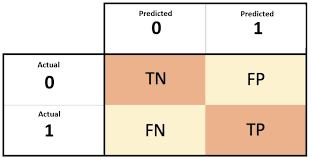

In [ ]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
cm

#Pneumonia-Class 0
#Normal   -Class 1

#TP: model predicted true & is true     = 172
#TN: model predicted false & is false   = 383
#FP: model predicted True & it is false = 07
#FN: model predicted false & is true    = 62

,0,1
0,383,7
1,62,172


In [ ]:
def pneumoniaPrediction(img):
    img = np.array(img)/255
    img = img.reshape(-1, 150, 150, 1)
    isPneumonic = model.predict(img)[0]
    imgClass = "Normal" if isPneumonic<0.5 else "Pneumonic"
    return imgClass

In [ ]:
pr = model.predict(x_test)
for i in range(len(pr)):
    if pr[i]>0.5:
        pr[i]=1
    else:
        pr[i]=0

20/20 [==============================] - 6s 275ms/step


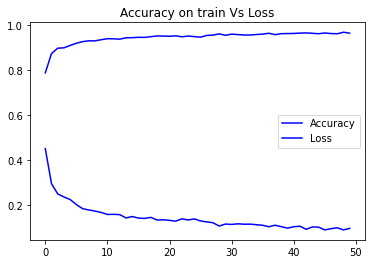

In [ ]:
# plot accuracy
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['loss'], color='blue', label='Loss')
plt.title('Accuracy on train Vs Loss')
plt.legend(loc='best')
plt.show()
     

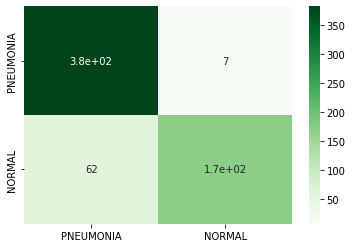

In [ ]:
sns.heatmap(cm, cmap="Greens", annot=True, xticklabels = labels,yticklabels = labels)
plt.show()